# GEM radix Lagrangean decomposition

In [1]:
REG_WEIGHT   = 0. #1e-4
MAX_NONZERO  = None #48*2
PREVENT_ZERO = True
TWO_PHASE    = True

In [2]:
%load_ext line_profiler

In [3]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [4]:
#ijomc = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')
ijomc = load_json_model('/home/laurence/ME/data/dynamicME/nominal_ijomc.json')

In [5]:
print(ijomc.optimize())
mu_crowd0 = ijomc.reactions.BIOMASS_Ec_iJO1366_core_53p95M
print(mu_crowd0)

<Solution 0.97 at 0x7fb78b6986d0>
BIOMASS_Ec_iJO1366_core_53p95M


In [175]:
a0s = [rxn.metabolites[ijomc.metabolites.crowding] for rxn in ijomc.metabolites.crowding.reactions]
# a0s

In [6]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

ex_rxns = [r for r in df_meas.ex_rxn.unique() if ijomc.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]
conds = df_meas.substrate.unique()

N_CONDS = len(conds)
#N_CONDS = 2

df_conds = pd.DataFrame([{'cond':r['substrate'], 'rxn':ex_rxn, 'lb':-10 if r['ex_rxn']==ex_rxn else 0, 'ub':1000., 'obj':0.} for i,r in df_meas.iterrows() for ex_rxn in ex_rxns])

if N_CONDS==1:
    df_conds = df_conds[ df_conds.cond=='acetate']
elif N_CONDS<=3:
    df_conds = df_conds[ df_conds.cond.isin(['glucose','acetate','succinate'][0:N_CONDS])]
else:
    df_conds = df_conds[ df_conds.cond.isin(conds[0:N_CONDS])]

df_conds.loc[ (df_conds.cond=='acetate') & (df_conds.rxn=='EX_ac_e'), 'lb'] = -20

# Make radix problem

In [7]:
from dynamicme.estimate import RadixEstimator

In [8]:
df_Y = df_meas.rename(columns={'growth_rate_1_h':'output', 'substrate':'cond'})
df_Y.loc[:,'output_id'] = 'BIOMASS_Ec_iJO1366_core_53p95M'
df_X = df_conds

In [9]:
from dynamicme.decomposition import LagrangeMaster, LagrangeSubmodel

In [10]:
conds = df_conds.cond.unique()
sub_dict = {}
for cond in conds:
    df_Xk = df_X[ df_X.cond==cond]
    df_Yk = df_Y[ df_Y.cond==cond]
    estk = RadixEstimator()
    estk.fit(ijomc, df_Xk, df_Yk, reg_weight = REG_WEIGHT, max_nonzero_binaries=MAX_NONZERO, optimize=False)    
    sub = LagrangeSubmodel(estk.stacker.model, cond)
    sub_dict[cond] = sub

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


In [ ]:
master = LagrangeMaster(estk.stacker.model)
master.add_submodels(sub_dict)

### Two-phase

In [ ]:
master.time_limit = 3*3600
#master.max_iter = 500
master.verbosity = 2
master.print_iter = 5
master.gaptol = 1e-3
master.absgaptol = 1e-3
feasible_method = 'enumerate'
alt_method = 'pool'
max_alt = 10    # Computationally expensive if too large. Might miss feasible solution if too small.
                # Can make adaptive if no feasible solution found for certain iterations.
if TWO_PHASE:
    sol_master = master.solve_relaxed(feasible_method=None)
    df_phase1 = pd.DataFrame(master.log_rows)
    
sol_master = master.optimize(feasible_method=feasible_method, max_alt=max_alt, alt_method=alt_method,
                            nogood_cuts = True) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
       0       1000     1e+100          0          0      1000       100         0  9.175333  0.016643  9.143867


/home/laurence/python_modules/dynamicme.git/dynamicme/decomposition.py:2145 UserWarning: Solution available but Master solver status=suboptimal (13).


Master solver status=suboptimal (13).
       5      67.78     1e+100      -3094          0     67.78       100      55.4  169.1267  0.067306  48.56249
Master solver status=suboptimal (13).
      10      43.08     1e+100 -1.066e+04          0     43.08       100      18.3  340.3065  0.151319  27.12141
      15      225.2     1e+100 -1.129e+05          0     225.2       100      62.5  487.4238  0.263276  22.21052
      20      227.7     1e+100 -5.499e+05          0     227.7       100      38.2  597.4814  0.548017  17.10634
Master solver status=suboptimal (13).
      25        181     1e+100 -1.398e+06          0       181       100      8.27  710.6746  0.767996  22.87248
      30      169.9     1e+100 -2.701e+06          0     169.9       100      1.15  812.1018  1.067464  21.79675
      35      167.1     1e+100 -3.831e+06          0     167.1       100     0.324  923.7047  2.195050  21.26261
      40      161.9     1e+100 -3.789e+06          0     161.9       100     0.323  1055.404  1

/home/laurence/python_modules/dynamicme.git/dynamicme/decomposition.py:2145 UserWarning: Solution available but Master solver status=time_limit (9).



Master solver status=time_limit (9).
       0    0.01377     1e+100    -0.7718    -0.7718    0.7856      5703  0.000881  1002.555  91.84940  910.6903
Master solver status=suboptimal (13).


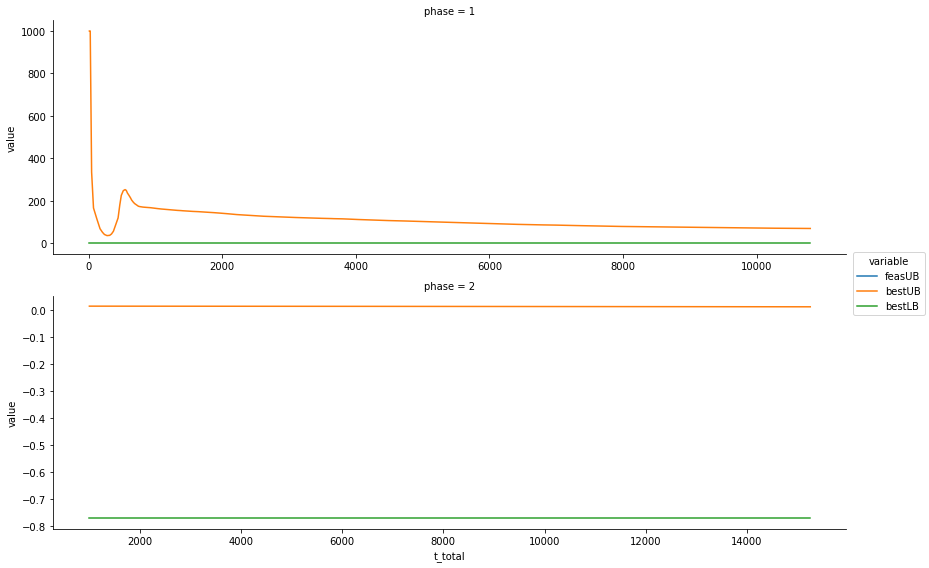

In [155]:
#xcol = 'iter'
xcol = 't_total'
df_phase1.loc[:,'phase'] = 1
df_phase2.loc[:,'phase'] = 2
dsplot = pd.concat([df_phase1, df_phase2])
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])
dsplot.loc[ dsplot.value>1e4, 'value'] = np.nan
dsplot.loc[ dsplot.value<-1e4, 'value'] = np.nan

g = sns.FacetGrid(dsplot, hue='variable', size=4, aspect=3, row='phase', sharey=False, sharex=False)
g.map(plt.plot, xcol,'value')
g.add_legend()

In [156]:
### Save stats
dsplot.to_csv('stats_10.csv', index=False)

In [73]:
df_phase2

,LB,bestLB,bestUB,delta,feasUB,gap,iter,relgap,res_u,t_master,t_sub,t_total,phase
0,-0.771794,-0.771794,0.013774,1.00,1.000000e+100,0.785567,0,5703.308002,0.000881,91.849401,910.690324,1002.555867,2
1,-2.993348,-0.771794,0.013034,0.50,1.000000e+100,0.784828,1,6021.392576,0.000950,106.909359,5522.560394,6632.032212,2
2,-5.778701,-0.771794,0.011386,0.25,1.000000e+100,0.783179,2,6878.548493,0.002227,101.567484,8519.390083,15252.996176,2


In [21]:
var_cons_dict = estk.var_cons_dict
powers = estk.powers
digits = estk.digits
radix  = estk.radix

In [78]:
if not sol_master:
    sol_masterk = sub.x_dict
#     feasUB = 1e100
#     for sub_ind,sub in iteritems(sub_dict):
#         yk = np.array([sub.x_dict[v.VarName] for v in sub._ys])        
#         obj_dict, feas_dict, sub_stats = master.check_feasible(yk)
#         feasUBk = sum(obj_dict.values())
#         print("feasUB for %s: %s" % (sub_ind, feasUBk))
#         if feasUBk < feasUB:
#             feasUB = feasUBk
#             sol_masterk = sub.x_dict
else:
    sol_masterk = sol_master

In [79]:
sol0 = sub.x_dict
sol_masterk = {}
for k,v in iteritems(sol0):
    if 'binary_' in k:
        vs = [sub.x_dict[k] for sub in sub_dict.values()]
        sol_masterk[k] = np.round(np.mean(vs))

# Save solution

import json

with open('optkeffs_ijo_10.json','w') as f:
    json.dump(sol_masterk, f)

# Check solution

In [166]:
kfit_dict = {}
for group_id, var_dict in iteritems(var_cons_dict):
    var = var_dict[0]
    cons = var_dict[1]
    a0  = var_dict[0][2]
    kfit = 0.
    for l,pwr in enumerate(powers):
        for k,digit in enumerate(digits):            
            yid = 'binary_%s%s%s' % (group_id,k,l)
            y   = sol_masterk[yid]
            kfit += y*a0*radix**pwr*digit
    kfit_dict[group_id] = kfit

kfit_changed = [(k,v, abs(v-a0)/a0) for k,v in iteritems(kfit_dict) if abs(v-a0)/a0>1e-6]
print('Changed keffs: %d/%d' % (len(kfit_changed), len(var_cons_dict)))

Changed keffs: 2018/2018


# Save keffs

In [168]:
import json

with open('/home/laurence/ME/data/dynamicME/keff_radix/kfit_dict_10.json','w') as f:
    json.dump(kfit_dict, f)

In [177]:
a0 = None

In [178]:
#----------------------------------------
# Starting from basal model
perrs = []
errs_fit = []
errs_unfit = []
csrcs = df_conds.cond.unique()
rows = []
for csrc in csrcs:        
    ijofit = load_json_model('/home/laurence/ME/data/dynamicME/nominal_ijomc.json')        
    #--------------------------------------------------
    # Constrain to medium
    df_condi = df_conds[ df_conds.cond==csrc]    
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']
    # Get unfit growth rate first
    crowding = ijofit.metabolites.get_by_id('crowding')
    if a0 is not None:
        for rxn in ijofit.metabolites.crowding.reactions:
            rxn._metabolites[crowding] = a0
    ijofit.optimize(solver='gurobi')
    mu_unfiti = ijofit.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    
    #--------------------------------------------------
    # Fitted    
    for rid,kfit in iteritems(kfit_dict):
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.add_metabolites({crowding:kfit}, combine=False)
    
    ijofit.optimize(solver='gurobi')
    
    mu_measi = df_meas[ df_meas.substrate==csrc].growth_rate_1_h.iloc[0]
    mu_fiti = ijofit.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
        
    err0= 100*(mu_unfiti-mu_measi)/mu_measi
    err = 100*(mu_fiti - mu_measi)/mu_measi
    derr= 100*(abs(err)-abs(err0))/abs(err0)
    perrs.append(err)
    errs_unfit.append(mu_unfiti - mu_measi)
    errs_fit.append(mu_fiti - mu_measi)
    print('Cond=%s. mu_meas=%g. mu_sim=%g (unfit=%g, error=%.3g%%). Error=%.3g%% (%.3g%% change)' % (
        csrc, mu_measi, mu_fiti, mu_unfiti, err0, err, derr))
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)        
        print('\t%s uptake=%g' % (rxn.id, rxn.x))
    
    rows.append({'substrate':csrc, 'mu_fit':mu_fiti, 'mu_unfit':mu_unfiti, 'mu_meas':mu_measi})

perrs = np.array(perrs)
errs_fit = np.array(errs_fit)
errs_unfit = np.array(errs_unfit)
tot_err = sum(abs(errs_fit))
tot_err0 = sum(abs(errs_unfit))
print("Absolute total error: %g"%(tot_err))
print("Total error change: %g%%"%( 100*(tot_err-tot_err0)/tot_err0  ))
print("Absolute percent error: %g%% -- %g%%"%(min(abs(perrs)), max(abs(perrs))))
print("Mean abs percent error = %g%%"%(np.mean(abs(perrs))))
print("Median abs percent error = %g%%"%(np.median(abs(perrs))))

Cond=glucose. mu_meas=0.74. mu_sim=0.743117 (unfit=0.972909, error=31.5%). Error=0.421% (-98.7% change)
	EX_glc__D_e uptake=-10
	EX_malt_e uptake=0
	EX_man_e uptake=0
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0
Cond=maltose. mu_meas=0.62. mu_sim=0.862881 (unfit=1.69369, error=173%). Error=39.2% (-77.4% change)
	EX_glc__D_e uptake=0
	EX_malt_e uptake=-6.22534
	EX_man_e uptake=0
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0.502694
Cond=mannose. mu_meas=0.56. mu_sim=0.662882 (unfit=0.965446, error=72.4%). Error=18.4% (-74.6% change)
	EX_glc__D_e uptake=0
	EX_malt_e uptake=0
	EX_man_e uptake=-10
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0
Cond=fructose. mu_meas=0.55. mu_sim=0.664529 (unfit=0.969159, error=76.

In [179]:
from scipy import stats

df_results = pd.DataFrame(rows)
dsplot = df_results.melt(['substrate','mu_meas'])
dsplot.loc[dsplot.variable=='mu_fit','model'] = 'Fit'
dsplot.loc[dsplot.variable=='mu_unfit','model'] = 'Unfit'
df_perf = dsplot.groupby('variable').apply(lambda x: pd.Series({
    'mdape':100*np.median(abs(x['value']-x['mu_meas'])/abs(x['mu_meas'])),
    'sse':sum( (x['value']-x['mu_meas'])**2 ),
    'rho':stats.spearmanr(x['mu_meas'],x['value'])[0],
    'r':stats.pearsonr(x['mu_meas'],x['value'])[0]
}))

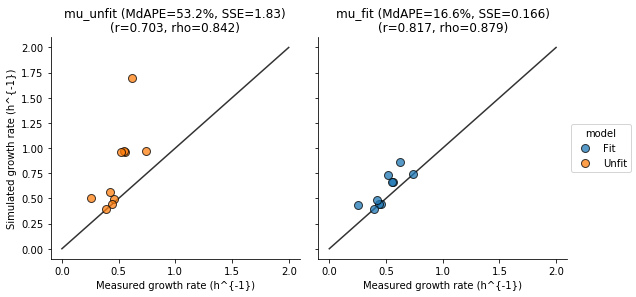

In [180]:
dsplot.variable = dsplot.variable.astype('category')
dsplot.model = dsplot.model.astype('category')
dsplot.variable.cat.reorder_categories(['mu_unfit','mu_fit'], inplace=True)
g = sns.FacetGrid(dsplot, col='variable', hue='model', size=4)
g.map(plt.plot, 'mu_meas','value', linestyle='None', marker='o', markeredgecolor='#000000', lw=0.2, markersize=8, alpha=0.75)
for ax in g.axes.flat:
    ax.plot([0,2],[0,2], zorder=1, color='#333333')
    mdl  = ax.get_title().replace('variable = ','')
    mdape= df_perf.loc[mdl].mdape
    sse  = df_perf.loc[mdl].sse
    r    = df_perf.loc[mdl].r
    rho  = df_perf.loc[mdl].rho    
    ax.set_title('%s (MdAPE=%.3g%%, SSE=%.3g)\n(r=%.3g, rho=%.3g)'%(mdl,mdape, sse, r,rho))
g.set_xlabels('Measured growth rate (h^{-1})')
g.set_ylabels('Simulated growth rate (h^{-1})')
g.add_legend()

g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf.svg')
g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf.eps')
g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf.pdf')

## Total error

In [182]:
y_sames = []
for y in sub._ys:
    sub1 = sub_dict['acetate']
    sub2 = sub_dict['glucose']
    y1 = sub1.x_dict[y.VarName]
    y2 = sub2.x_dict[y.VarName]
    y_sames.append(abs(y1-y2)<1e-10)
    #print('%20.18s%12.10s%12.10s%12.10s'%(y.VarName,y1,y2, abs(y1-y2)<1e-10))    

print('num same = %s/%s'%(sum(y_sames), len(y_sames)))

num same = 6054/6054
